## 1. 라이브러리 설치 및 불러오기  
YOLO 모델을 실행하기 위한 환경을 구성하는 코드입니다.  
필요한 패키지를 설치하고, 이미지 처리 및 데이터 로딩에 필요한 라이브러리를 불러옵니다.

> ✅ 설치 패키지
- `ultralytics`: YOLO 모델 실행 및 학습
- `opencv-python`: 이미지 로딩 및 전처리
- `numpy`, `matplotlib`: 데이터 처리 및 시각화

> ✅ 불러오는 핵심 라이브러리
- `torch`, `torchvision`: 모델 학습 및 데이터 전처리
- `ultralytics.YOLO`: YOLO 모델 로딩
- `cv2`, `numpy`: 이미지 처리 및 수치 계산
- `tqdm`, `matplotlib.pyplot`: 시각화 및 진행 표시

In [1]:
!pip install ultralytics opencv-python numpy matplotlib tqdm pyyaml -q

import os
import cv2
import torch
import yaml
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from ultralytics import YOLO
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.1 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which is inco

## 2. 랜덤 시드 고정

실험의 일관성을 유지하기 위해 `random`, `numpy`, `torch`의 시드를 고정합니다.  

In [2]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
seed_everything()

## 3. 데이터 경로 설정 및 YAML 파일 로드
`data.yaml` 파일을 불러와 학습(train), 검증(val) 데이터의 경로를 설정합니다.

> ✅ 학습 데이터는 모델을 학습시키는 데 사용되며,  
> ✅ 검증 데이터는 학습 중 모델의 성능을 평가하고 과적합 여부를 확인하는 데 사용됩니다.

In [3]:
DATA_YAML_PATH = "/kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/data.yaml"

with open(DATA_YAML_PATH, "r", encoding="utf-8") as f:
    data_yaml = yaml.safe_load(f)

DATASET_PATH = os.path.dirname(DATA_YAML_PATH)
TRAIN_IMAGES = os.path.join(DATASET_PATH, data_yaml["train"].replace("../", ""))
VALID_IMAGES = os.path.join(DATASET_PATH, data_yaml["val"].replace("../", ""))

print(DATASET_PATH)
print(TRAIN_IMAGES)
print(VALID_IMAGES)

/kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE
/kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/train/images
/kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/valid/images


## 4. 데이터셋 클래스 정의 및 로드  
객체 탐지 모델을 위한 이미지 데이터셋을 생성하고 불러오는 과정입니다.  
OpenCV와 glob을 활용하여 이미지를 로드하고, torchvision.transforms를 적용해  
크기 변환 및 텐서 변환을 수행합니다.  
마지막으로 샘플 이미지를 시각화하여 데이터가 올바르게 불러와졌는지 확인합니다.

훈련 데이터 샘플


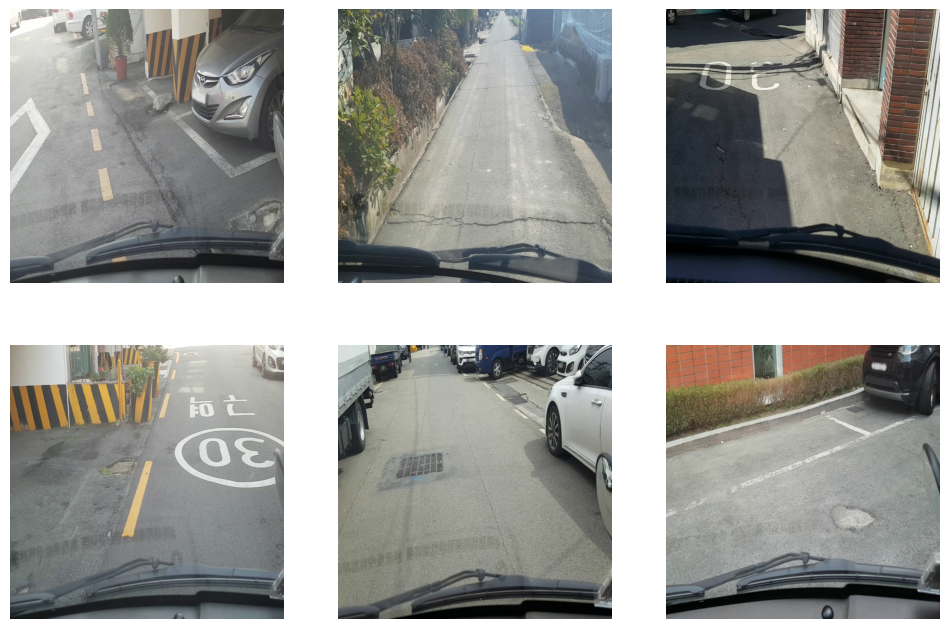

In [4]:
class PotholeDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = glob(os.path.join(image_dir, "*.jpg"))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        return self.transform(img) if self.transform else img


transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
])

train_loader = DataLoader(PotholeDataset(TRAIN_IMAGES, transform), batch_size=16, shuffle=True)
valid_loader = DataLoader(PotholeDataset(VALID_IMAGES, transform), batch_size=16, shuffle=False)


def show_sample_images(image_loader):
    sample_images = next(iter(image_loader))

    fig, ax = plt.subplots(2, 3, figsize=(12, 8))

    for i, img in enumerate(sample_images[:6]):
        ax[i // 3, i % 3].imshow(img.permute(1, 2, 0).numpy())
        ax[i // 3, i % 3].axis("off")

    plt.show()


print("훈련 데이터 샘플")
show_sample_images(train_loader)

## 5. 랜덤 샘플 시각화 (이미지 + 라벨)

학습 이미지 중 하나를 랜덤으로 선택하여 해당 이미지와 라벨 정보를 시각화합니다.  
라벨은 YOLO 포맷의 좌표 정보를 바탕으로 이미지 위에 바운딩 박스를 그려 확인합니다.


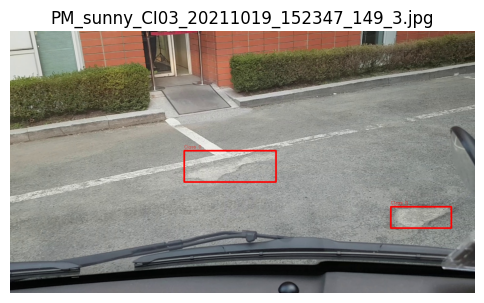

In [5]:
IMAGE_DIR = "/kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/train/images"
IMAGE_PATHS = sorted(glob(os.path.join(IMAGE_DIR, "*.jpg")))

IMG_PATH = random.choice(IMAGE_PATHS)
LABEL_PATH = IMG_PATH.replace("images", "labels").replace(".jpg", ".txt")

img = cv2.imread(IMG_PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w, _ = img.shape

if os.path.exists(LABEL_PATH):
    with open(LABEL_PATH, "r") as f:
        for line in f.readlines():
            cls, cx, cy, bw, bh = map(float, line.strip().split())
            x1 = int((cx - bw / 2) * w)
            y1 = int((cy - bh / 2) * h)
            x2 = int((cx + bw / 2) * w)
            y2 = int((cy + bh / 2) * h)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 5)
            cv2.putText(img, f"Class {int(cls)}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 1)
else:
    print("라벨 파일이 존재하지 않습니다:", LABEL_PATH)

# 시각화
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis("off")
plt.title(os.path.basename(IMG_PATH))
plt.show()

## 6. YOLO 모델 학습  
YOLO 모델을 불러와 학습을 수행하는 코드입니다.  
데이터셋 경로를 지정하고, 에포크 수 및 배치 크기를 설정하여 학습을 진행합니다.
- 기본적으로 YOLO 학습 결과는 `runs/detect/train` 디렉토리에 저장됩니다.  
- 캐글 환경에서는 저장 경로를 직접 지정해야 합니다.
- `project` 및 `name` 파라미터를 사용하여 원하는 경로에 저장할 수 있습니다.

In [6]:
model = YOLO("yolov8m.pt")

def train_model():
    results = model.train(
        data=DATA_YAML_PATH,
        epochs=30,
        imgsz=640,
        batch=32,
        workers=4,
        device="0",
        project="/kaggle/working",
        name="pothole_yolov8_train",
        patience=10,
        hsv_h=0.015, hsv_s=0.7, hsv_v=0.4,
        degrees=5, translate=0.1, scale=0.5, shear=0.1,
        mosaic=1.0, mixup=0.2
    )
    return results

results = train_model()

100%|██████████| 49.7M/49.7M [00:00<00:00, 396MB/s]


Ultralytics 8.3.123 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/data.yaml, epochs=30, time=None, patience=10, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=4, project=/kaggle/working, name=pothole_yolov8_train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, s

100%|██████████| 755k/755k [00:00<00:00, 40.0MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 98.8MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.4±0.2 ms, read: 92.7±13.9 MB/s, size: 729.9 KB)


train: Scanning /kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/train/labels... 24279 images, 0 backgrounds, 11 corrupt: 100%|██████████| 24290/24290 [01:59<00:00, 203.52it/s]

train: /kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/train/images/AM_sunny_CI02_20211020_112426_804_3.jpg: ignoring corrupt image/label: cannot identify image file '/kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/train/images/AM_sunny_CI02_20211020_112426_804_3.jpg'
train: /kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/train/images/AM_sunny_CI02_20211020_112426_805_1.jpg: ignoring corrupt image/label: [Errno 30] Read-only file system: '/kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/train/images/AM_sunny_CI02_20211020_112426_805_1.jpg'
train: /kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/train/images/AM_sunny_CI02_20211020_112426_806_3.jpg: ignoring corrupt image/label: cannot identify image file '/kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/train/images/AM_sunny_CI02_20211020_112426_806_3.jpg'
train: /kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/train/images/AM_sunny_CI02_20211020_1124

WARNING ⚠️ train: Cache directory /kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 53.3±39.5 MB/s, size: 695.1 KB)


val: Scanning /kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/valid/labels... 5998 images, 0 backgrounds, 2 corrupt: 100%|██████████| 6000/6000 [00:31<00:00, 190.53it/s]

val: /kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/valid/images/AM_sunny_CI02_20211020_112426_809_2.jpg: ignoring corrupt image/label: broken data stream when reading image file
val: /kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/valid/images/AM_sunny_CI02_20211020_112426_813_1.jpg: ignoring corrupt image/label: cannot identify image file '/kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/valid/images/AM_sunny_CI02_20211020_112426_813_1.jpg'


WARNING ⚠️ val: Cache directory /kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/valid is not writeable, cache not saved.
Plotting labels to /kaggle/working/pothole_yolov8_train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/pothole_yolov8_train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      13.7G      1.724      1.719      1.258        142        640: 100%|██████████| 759/759 [14:08<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:58<00:00,  1.60it/s]


                   all       5998      15797      0.661      0.492      0.558      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      13.8G      1.604      1.327      1.155        167        640: 100%|██████████| 759/759 [14:08<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:01<00:00,  1.54it/s]


                   all       5998      15797      0.643      0.503      0.567      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      13.9G      1.637      1.366      1.174        137        640: 100%|██████████| 759/759 [14:04<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:00<00:00,  1.56it/s]


                   all       5998      15797      0.615      0.469       0.52       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      13.8G      1.685      1.411      1.207        149        640: 100%|██████████| 759/759 [14:01<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:01<00:00,  1.52it/s]


                   all       5998      15797      0.642      0.532      0.584      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      13.9G      1.616      1.313      1.177        180        640: 100%|██████████| 759/759 [14:02<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:59<00:00,  1.59it/s]


                   all       5998      15797      0.719      0.575      0.662      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      13.8G      1.556      1.223      1.152        136        640: 100%|██████████| 759/759 [14:01<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:57<00:00,  1.65it/s]


                   all       5998      15797      0.721      0.588      0.672      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      13.9G      1.519       1.17      1.137        145        640: 100%|██████████| 759/759 [14:01<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:57<00:00,  1.62it/s]


                   all       5998      15797      0.755      0.656      0.737      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      13.8G      1.481      1.121      1.122        115        640: 100%|██████████| 759/759 [14:00<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:57<00:00,  1.65it/s]


                   all       5998      15797      0.773      0.662      0.748      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      13.9G      1.452      1.078       1.11        101        640: 100%|██████████| 759/759 [14:00<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:57<00:00,  1.64it/s]


                   all       5998      15797      0.788      0.669      0.767       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      13.8G      1.427      1.046      1.098        109        640: 100%|██████████| 759/759 [14:00<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:57<00:00,  1.64it/s]


                   all       5998      15797        0.8      0.691      0.788      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      13.9G      1.405      1.016      1.088        171        640: 100%|██████████| 759/759 [14:00<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:57<00:00,  1.65it/s]


                   all       5998      15797      0.807      0.708        0.8      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      13.8G      1.387     0.9889      1.079        114        640: 100%|██████████| 759/759 [14:00<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:56<00:00,  1.66it/s]


                   all       5998      15797      0.807      0.713      0.808       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      13.9G      1.371     0.9689      1.072        168        640: 100%|██████████| 759/759 [14:00<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:57<00:00,  1.65it/s]


                   all       5998      15797      0.824      0.737      0.832      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      13.8G      1.347     0.9385       1.06        159        640: 100%|██████████| 759/759 [14:00<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:57<00:00,  1.64it/s]

                   all       5998      15797      0.824      0.743      0.837      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      13.9G      1.334     0.9199      1.057        139        640: 100%|██████████| 759/759 [14:00<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:58<00:00,  1.62it/s]

                   all       5998      15797      0.833      0.755      0.847       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      13.8G       1.31     0.8962       1.05        151        640: 100%|██████████| 759/759 [14:00<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:57<00:00,  1.64it/s]

                   all       5998      15797      0.831      0.763      0.852      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      13.9G      1.301     0.8829      1.046        116        640: 100%|██████████| 759/759 [14:00<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:57<00:00,  1.64it/s]

                   all       5998      15797      0.842      0.767      0.858      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      13.8G      1.283     0.8613      1.039         80        640: 100%|██████████| 759/759 [14:00<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:57<00:00,  1.64it/s]

                   all       5998      15797      0.853      0.776      0.868      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      13.9G       1.27     0.8417      1.034        117        640: 100%|██████████| 759/759 [14:00<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:57<00:00,  1.63it/s]

                   all       5998      15797      0.848       0.78      0.866      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      13.8G      1.257     0.8302      1.028        120        640: 100%|██████████| 759/759 [14:00<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:57<00:00,  1.65it/s]

                   all       5998      15797      0.864      0.786      0.879      0.594


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      13.9G       1.14     0.6834     0.9943         67        640: 100%|██████████| 759/759 [13:59<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:57<00:00,  1.65it/s]

                   all       5998      15797      0.858      0.794      0.879      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      13.8G      1.121     0.6595     0.9876         61        640: 100%|██████████| 759/759 [13:57<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:00<00:00,  1.57it/s]

                   all       5998      15797      0.866      0.796      0.885      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      13.9G      1.103     0.6345     0.9803         69        640: 100%|██████████| 759/759 [13:57<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:57<00:00,  1.65it/s]

                   all       5998      15797      0.863      0.802      0.887      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      13.8G      1.083     0.6159     0.9738         45        640: 100%|██████████| 759/759 [13:57<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:57<00:00,  1.64it/s]

                   all       5998      15797      0.868      0.814      0.896      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      13.9G      1.064     0.5942     0.9651         72        640: 100%|██████████| 759/759 [13:57<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:57<00:00,  1.65it/s]

                   all       5998      15797      0.875      0.812      0.899       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      13.8G      1.049     0.5828     0.9633         47        640: 100%|██████████| 759/759 [13:57<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:57<00:00,  1.62it/s]

                   all       5998      15797      0.879      0.817      0.902      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      13.9G      1.033     0.5635     0.9576         57        640: 100%|██████████| 759/759 [13:57<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:57<00:00,  1.65it/s]

                   all       5998      15797      0.883      0.819      0.905      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      13.8G      1.012     0.5461     0.9506         55        640: 100%|██████████| 759/759 [13:57<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:56<00:00,  1.66it/s]

                   all       5998      15797      0.883      0.824      0.906       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      13.9G     0.9975       0.53     0.9438         41        640: 100%|██████████| 759/759 [13:57<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:57<00:00,  1.64it/s]

                   all       5998      15797      0.877       0.83      0.908      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      13.8G     0.9787     0.5152     0.9399         44        640: 100%|██████████| 759/759 [13:57<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:57<00:00,  1.65it/s]

                   all       5998      15797      0.882      0.828      0.909      0.634



30 epochs completed in 7.499 hours.
Optimizer stripped from /kaggle/working/pothole_yolov8_train/weights/last.pt, 52.0MB
Optimizer stripped from /kaggle/working/pothole_yolov8_train/weights/best.pt, 52.0MB

Validating /kaggle/working/pothole_yolov8_train/weights/best.pt...
Ultralytics 8.3.123 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:02<00:00,  1.51it/s]


                   all       5998      15797      0.882      0.828      0.909      0.634


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 5.9ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /kaggle/working/pothole_yolov8_train


## 7. 학습 결과 시각화

YOLO 모델 학습 과정에서 저장된 손실 그래프(`results.png`)를 불러와 시각화하는 코드입니다.  
`matplotlib`을 사용하여 이미지를 출력하고, 그래프 외 요소는 제거하여 깔끔하게 보여줍니다.

- 기본적으로 학습 결과는 `runs/detect/train` 디렉토리에 저장됩니다.  
- 캐글 환경에서는 저장된 경로를 명시적으로 지정해주어야 합니다.


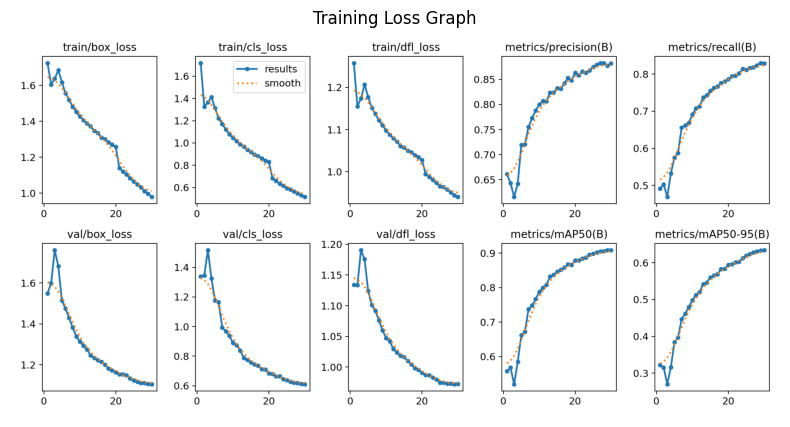

In [7]:
TRAIN_RUN_DIR = "/kaggle/working/pothole_yolov8_train"
loss_plot_path = f"{TRAIN_RUN_DIR}/results.png"

img = plt.imread(loss_plot_path)
plt.figure(figsize=(10, 5))
plt.imshow(img)
plt.axis("off")
plt.title("Training Loss Graph")
plt.show()

## 8. 모델 성능 평가  
학습된 YOLO 모델을 불러와 검증 데이터셋을 이용해 성능을 평가하는 코드입니다.  
`val()` 함수를 사용하여 `mAP`, `Precision`, `Recall` 등의 성능 지표를 계산합니다.

- 캐글 환경에서는 모델이 저장된 경로를 지정해줘야 합니다.


In [8]:
model = YOLO("/kaggle/working/pothole_yolov8_train/weights/best.pt")

val_results = model.val(data=DATA_YAML_PATH, split="val")

print("검증 데이터 평가 결과:")
print(f"mAP50: {val_results.box.map50:.4f}")
print(f"mAP50-95: {val_results.box.map:.4f}")
print(f"Precision: {val_results.box.mp:.4f}")
print(f"Recall: {val_results.box.mr:.4f}")

Ultralytics 8.3.123 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.1±0.2 ms, read: 830.6±136.6 MB/s, size: 554.1 KB)


val: Scanning /kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/valid/labels... 5998 images, 0 backgrounds, 2 corrupt: 100%|██████████| 6000/6000 [00:15<00:00, 394.33it/s]

val: /kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/valid/images/AM_sunny_CI02_20211020_112426_809_2.jpg: ignoring corrupt image/label: broken data stream when reading image file
val: /kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/valid/images/AM_sunny_CI02_20211020_112426_813_1.jpg: ignoring corrupt image/label: cannot identify image file '/kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/valid/images/AM_sunny_CI02_20211020_112426_813_1.jpg'


WARNING ⚠️ val: Cache directory /kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/valid is not writeable, cache not saved.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [01:03<00:00,  5.92it/s]


                   all       5998      15797      0.881      0.829      0.909      0.635


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 6.2ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/val
검증 데이터 평가 결과:
mAP50: 0.9086
mAP50-95: 0.6351
Precision: 0.8806
Recall: 0.8291


## 9. 모델 추론 및 시각화
학습된 YOLO 모델을 사용하여 테스트 데이터셋에서 임의의 이미지를 추론합니다.

- 포트홀을 감지하지 못하면 아무것도 표시되지 않습니다.


image 1/1 /kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/test/images/AM_sunny_CI02_20211102_095534_286_2.jpg: 384x640 1 pothole, 58.1ms
Speed: 2.1ms preprocess, 58.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


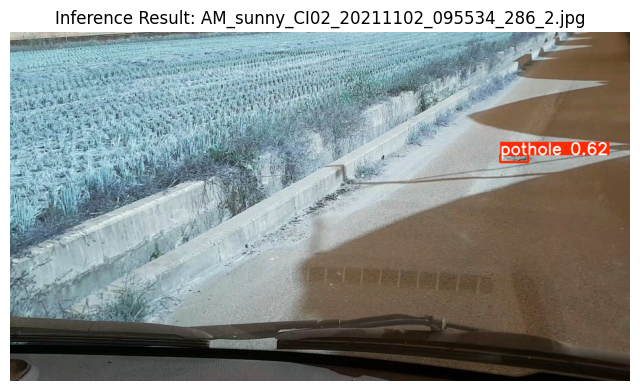

In [10]:
model = YOLO("/kaggle/working/pothole_yolov8_train/weights/best.pt")

TEST_IMAGE_DIR = "/kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/test/images"
test_image_paths = sorted(glob(os.path.join(TEST_IMAGE_DIR, "*.jpg")))
test_img_path = random.choice(test_image_paths)

results = model.predict(source=test_img_path, conf=0.25, imgsz=640, save=False)

result_img = results[0].plot()

plt.figure(figsize=(8, 6))
plt.imshow(result_img)
plt.axis("off")
plt.title(f"Inference Result: {os.path.basename(test_img_path)}")
plt.show()

## 10. 제출 파일 생성 (submission.csv)
테스트 이미지에 대해 학습된 YOLO 모델을 사용하여 객체 탐지를 수행하고,  
예측 결과를 제출 형식에 맞춰 `submission.csv` 파일로 저장합니다.

- 한 이미지당 박스 하나만 제출하며, confidence가 가장 높은 박스를 사용합니다.
- 객체를 감지하지 못한 경우, `ClassId`와 바운딩 박스 좌표는 모두 0으로 처리합니다.
- 이미지가 손상되었거나 열리지 않는 경우에도 에러 없이 넘어가도록 예외 처리를 포함합니다.
- Output 경로인 /kagggle/working/에 저장됩니다.

In [11]:
import pandas as pd

model = YOLO("/kaggle/working/pothole_yolov8_train/weights/best.pt")

TEST_IMG_DIR = "/kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/test/images"
test_image_paths = sorted(glob(os.path.join(TEST_IMG_DIR, "*.jpg")))

submission_rows = []

for img_path in test_image_paths:
    image_id = os.path.basename(img_path)

    if cv2.imread(img_path) is None:
        print(f"이미지 로드 실패: {image_id}")
        submission_rows.append({
            "ImageId": image_id,
            "ClassId": 0,
            "X": 0,
            "Y": 0,
            "Width": 0,
            "Height": 0,
        })
        continue

    results = model.predict(source=img_path, conf=0.25, imgsz=640, save=False)
    result = results[0]

    if len(result.boxes) > 0:
        boxes = result.boxes
        best_idx = boxes.conf.argmax().item()
        cls_id = int(boxes.cls[best_idx].item())
        cx, cy, w, h = boxes.xywhn[best_idx].tolist()

        submission_rows.append({
            "ImageId": image_id,
            "ClassId": cls_id,
            "X": round(cx, 6),
            "Y": round(cy, 6),
            "Width": round(w, 6),
            "Height": round(h, 6),
        })
    else:
        submission_rows.append({
            "ImageId": image_id,
            "ClassId": 0,
            "X": 0,
            "Y": 0,
            "Width": 0,
            "Height": 0,
        })

submission_df = pd.DataFrame(submission_rows, columns=["ImageId", "ClassId", "X", "Y", "Width", "Height"])
submission_path = "/kaggle/working/submission.csv"
submission_df.to_csv(submission_path, index=False)
print(f"제출 파일 저장 완료: {submission_path}")


image 1/1 /kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/test/images/AM_sunny_CI01_20210916_105931_11_117_2.jpg: 384x640 1 pothole, 13.9ms
Speed: 2.6ms preprocess, 13.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/test/images/AM_sunny_CI01_20210916_105931_11_118_2.jpg: 384x640 (no detections), 13.3ms
Speed: 1.9ms preprocess, 13.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/test/images/AM_sunny_CI01_20210916_105931_11_134_1.jpg: 384x640 (no detections), 13.3ms
Speed: 1.9ms preprocess, 13.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /kaggle/input/pothole-detection-challenge/SSAFY_AI_CHALLENGE/test/images/AM_sunny_CI01_20210916_105931_11_137_2.jpg: 384x640 1 pothole, 13.2ms
Speed: 1.9ms preprocess, 13.2ms inference, 1.3ms postprocess per image at shape (